# <b style="color:#537FBF">Cancer</b>, from an <b style="color:#EB1960">omics</b> perspective

##

![<b style="color:#C0CF96">Many 'omics'</b>: <b style="color:#A6A440">genomics</b>, <b style="color:#A6A440">transcriptomics</b>, <b style="color:#A6A440">proteomics</b>, etc...](./images/dancer-cell.jpeg)

##

![<b style="color:#A6A440">Cells</b> <b style="color:#537FBF">divide</b> and <b style="color:#537FBF">accrue mutations</b>](./images/cancer-an-overview.jpeg)

## 

![Things can <b style="color:#C0CF96">go wrong</b> at the <b style="color:#A6A440">omics</b> level](./images/cancer-cell.jpeg)

# Why should <em style="color:#537FBF">you</em> care?

##

- Many diseases are caused by an <b style="color:#A6A440">omics</b> issue

::: {.fragment fragment-index=2}

- When so, other data is a <b style="color:#C0CF96">proxy</b><sup>1</sup>

:::
::: {.incremental}

-  <b style="color:#EB1960">heterogenous tumors</b>?: <b style="color:#A6A440">single-cell omics</b>

:::
::: {.incremental}

- Symptoms may be caused by <b style="color:#A6A440">omics</b> issues
  - <b style="color:#A6A440">Proteomics</b> enables better design of treatments?
  
:::

::: {.fragment fragment-index=2}
<small><small><sup><sup>1)</sup></sup>
    Well, environmental factors can be a cause, but limited ability to affect them
</small></small>
:::

# Now that you care...

## <b style="color:#C0CF96">Hands-on Learning Experience™</b>

![<a href='https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-8559/'>https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-8559/</a>](./images/sce-atlas.png)

## Dataset Details - Where?

> To build a living biobank, we established a <b style="color:#537FBF">biopsy</b> pipeline, collecting samples from patients diagnosed with <b style="color:#A6A440">epithelial ovarian cancer</b> treated at the <b style="color:#EB1960">Christie Hospital</b>.
>
> -- @ovarian-cancer-living-biobank

(<b style="color:#EB1960">Christie Hospital</b> is in Manchester)

## Dataset Details - Who?

> Between <b style="color:#EB1960">May 2016</b> and <b style="color:#EB1960">June 2019</b>, we collected <b style="color:#C0CF96">312 samples</b> from patients with <b style="color:#A6A440">chemo-naïve</b> and <b style="color:#A6A440">relapsed disease</b>, either as <b style="color:#537FBF">solid biopsies</b> or as <b style="color:#537FBF">ascites</b> (<b style="color:#EB1960">Fig. 1a</b>)
>
> Ten patients had <b style="color:#A6A440">HGSOC</b> while two had <b style="color:#A6A440">mucinous ovarian carcinoma</b>. <b style="color:#537FBF">Longitudinal biopsies</b> were collected from three patients.
>
> -- @ovarian-cancer-living-biobank

## Dataset Details - How?

> The primer contains:
>
> * an Illumina TruSeq Read 1 (read 1 sequencing primer)
>
> * 16 nt 10x Barcode
>
> * 12 nt <b style="color:#A6A440">unique molecular identifier (UMI)</b>
>
> * 30 nt poly(dT) sequence 
>
> Barcoded, full-length <b style="color:#A6A440">cDNA</b> is amplified via <b style="color:#537FBF">PCR</b> to generate sufficient mass for library construction. 
>
> -- @ovarian-cancer-living-biobank

## Load the Data

In [ ]:
#| echo: true
file.path = './localdata/E-MTAB-8559-quantification-raw-files/'
raw.counts <- as(Matrix::readMM(
    paste(
        file.path,
        'E-MTAB-8559.aggregated_filtered_counts.mtx',
        sep=''
    )
), 'CsparseMatrix')
dim(raw.counts)

[1] 23284 19880

## Load the Data

In [ ]:
#| echo: true
row.info <- read.table(
    paste(
        file.path,
        'E-MTAB-8559.aggregated_filtered_counts.mtx_rows',
        sep=''
    ),
    header=FALSE,
    col.names=c("Ensembl.ID", "Redundant")
)

# Drop duplicate field in row.info
row.info <- row.info['Ensembl.ID']
rownames(raw.counts) <- row.info$Ensembl.ID

In [ ]:
print(head(row.info))

       Ensembl.ID
1 ENSG00000000003
2 ENSG00000000419
3 ENSG00000000457
4 ENSG00000000460
5 ENSG00000000938
6 ENSG00000000971


## Load the Data

In [ ]:
#| echo: true
col.info <- read.table(
    paste(
        file.path,
        'E-MTAB-8559.aggregated_filtered_counts.mtx_cols',
        sep=''
    ),
    header=FALSE,
    col.names=c('Cell.ID')
)
colnames(raw.counts) <- col.info$Cell.ID

In [ ]:
print(head(col.info))

                        Cell.ID
1 SAMEA6492740-AAACCCACAGTTAGGG
2 SAMEA6492740-AAACCCACATGTGTCA
3 SAMEA6492740-AAACCCAGTCGCATGC
4 SAMEA6492740-AAACCCAGTCTTTCAT
5 SAMEA6492740-AAACCCATCCGTGTCT
6 SAMEA6492740-AAACCCATCCTCTCTT


## Load the Metadata

In [ ]:
#| echo: true
# Load in the experimental design matrix
exp.design.table <- read.table(
    './localdata/ExpDesign-E-MTAB-8559.tsv',
    header=TRUE,
    sep='\t'
)

# We can see we have four patients in our dataset
print(unique(exp.design.table$Sample.Characteristic.individual))

[1] "38b"  "59"   "74-1" "79"  


##

In [ ]:
#| echo: true
# For reproducibility
set.seed(0)

# Convenient data container
library(SingleCellExperiment)

# Libraries for scRNA analysis
library(scran)
library(scater)

# Library for cluster analysis
library(bluster)

## 

In [ ]:
#| echo: true
# Store as a SingleCellExperiment object for convenience
ovarian.sce <- SingleCellExperiment(
    assays=list(counts=raw.counts),
)

# Add patient metadata
ovarian.sce$patient <- exp.design.table$Sample.Characteristic.individual.

# Take a peak at internal data structure
ovarian.sce

class: SingleCellExperiment 
dim: 23284 19880 
metadata(0):
assays(1): counts
rownames(23284): ENSG00000000003 ENSG00000000419 ... ENSG00000289701
  ENSG00000289716
rowData names(0):
colnames(19880): SAMEA6492740-AAACCCACAGTTAGGG
  SAMEA6492740-AAACCCACATGTGTCA ... SAMEA6492743-TTTGTTGGTCCTGGTG
  SAMEA6492743-TTTGTTGTCAGATTGC
colData names(1): patient
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

## Why So Much Preprocessing?

![ELI5: Wet-lab work is <em>hard</em>](./images/amplification.jpeg)

##

In [ ]:
#| echo: true
ovarian.sce <- scuttle::logNormCounts(ovarian.sce)
ovarian.sce

class: SingleCellExperiment 
dim: 23284 19880 
metadata(0):
assays(2): counts logcounts
rownames(23284): ENSG00000000003 ENSG00000000419 ... ENSG00000289701
  ENSG00000289716
rowData names(0):
colnames(19880): SAMEA6492740-AAACCCACAGTTAGGG
  SAMEA6492740-AAACCCACATGTGTCA ... SAMEA6492743-TTTGTTGGTCCTGGTG
  SAMEA6492743-TTTGTTGTCAGATTGC
colData names(2): patient sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

##

In [ ]:
#| echo: true
ovarian.sce <- scran::fixedPCA(
    ovarian.sce,
    rank=14,
    subset.row=NULL,
    assay.type="logcounts"
)

<br>

In [ ]:
#| echo: true
ovarian.sce <- scater::runTSNE(
    ovarian.sce,
    dimred="PCA"
)

##

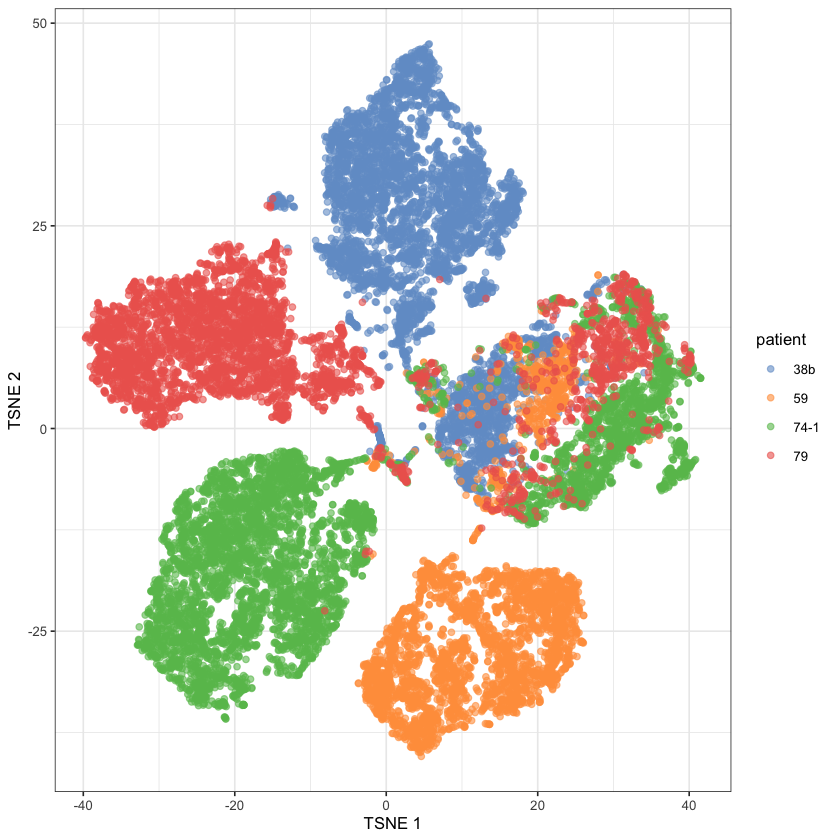

In [ ]:
#| echo: true
plotReducedDim(ovarian.sce, dimred="TSNE", colour_by="patient")

## Identifying stromals

In [ ]:
#| echo: true
ovarian.sce$tumor.stromal.clusters <- scran::clusterCells(
    ovarian.sce,
    use.dimred="TSNE",
    BLUSPARAM=bluster::KmeansParam(centers=5)
)

<br>

In [ ]:
#| echo: true

# We'll assign clusters by eye since it's obvious
ovarian.sce$tumor.or.stromal <- "Stromal"
ovarian.sce$tumor.or.stromal[ovarian.sce$tumor.stromal.clusters==1] <- "Tumor.1"
ovarian.sce$tumor.or.stromal[ovarian.sce$tumor.stromal.clusters==2] <- "Tumor.2"
ovarian.sce$tumor.or.stromal[ovarian.sce$tumor.stromal.clusters==4] <- "Tumor.3"
ovarian.sce$tumor.or.stromal[ovarian.sce$tumor.stromal.clusters==5] <- "Tumor.4"


##

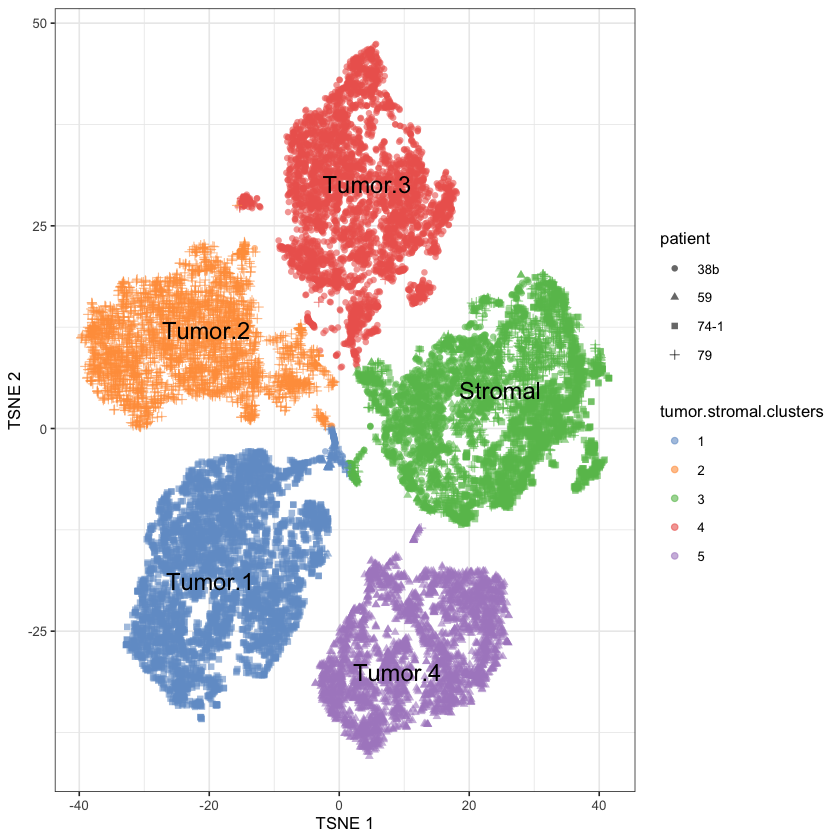

In [ ]:
#| echo: true
plotReducedDim(
    ovarian.sce,
    "TSNE",
    colour_by="tumor.stromal.clusters",
    text_by="tumor.or.stromal",
    shape_by="patient"
)

##

In [ ]:
#| echo: true
marker.info <- scran::scoreMarkers(
    ovarian.sce,
    ovarian.sce$tumor.stromal.clusters
)

In [ ]:
#| echo: true
cluster <- "3" # the stromal cluster
diff.exp.gene <- rownames(ovarian.sce)[
    order(marker.info[[cluster]]$mean.AUC, decreasing=TRUE)[[1]]
]
print(diff.exp.gene)

[1] "ENSG00000106366"


In [ ]:
#| echo: true
plotReducedDim(
    ovarian.sce,
    "TSNE",
    colour_by=diff.exp.gene,
    shape_by="patient",
    text_by="tumor.or.stromal",
    text_colour="cyan"
) +
    ggtitle("Ovarian Cancer Cells by SERPINE1 (ENSG00000106366) Expression") +
    theme(
        panel.background = element_rect(fill = "darkblue"),
        plot.background = element_rect(fill = "cyan")
    )

## 

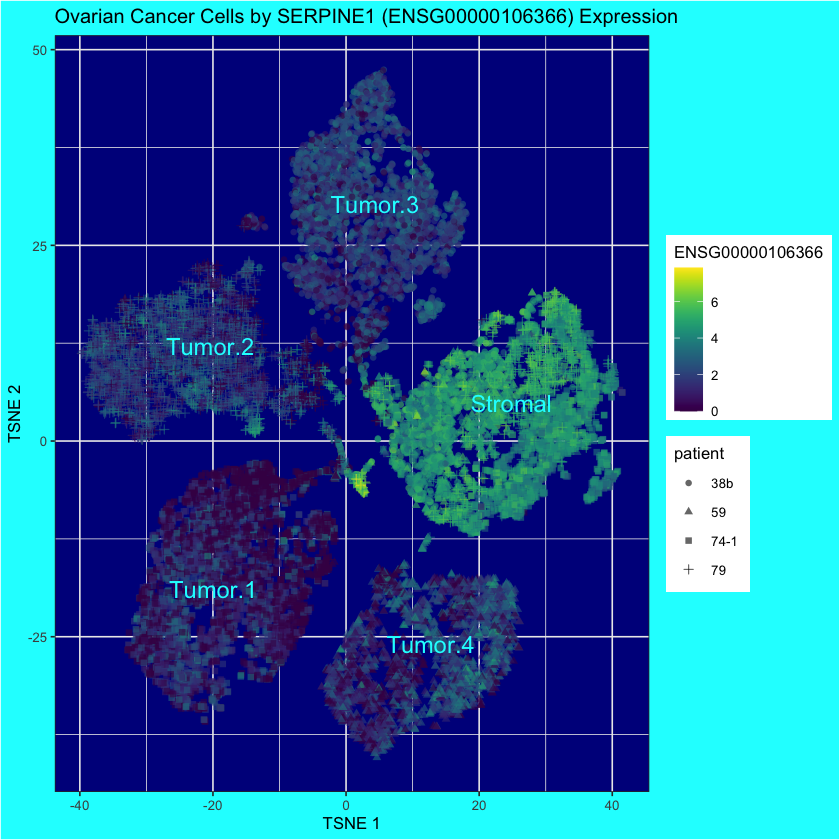

In [ ]:
#| echo: false
plotReducedDim(
    ovarian.sce,
    "TSNE",
    colour_by=diff.exp.gene,
    shape_by="patient",
    text_by="tumor.or.stromal",
    text_colour="cyan"
) +
    ggtitle("Ovarian Cancer Cells by SERPINE1 (ENSG00000106366) Expression") +
    theme(
        panel.background = element_rect(fill = "darkblue"),
        plot.background = element_rect(fill = "cyan")
    )

## SERPINE1

![PAI-1, the protein encoded by SERPINE1, is related to cancer!](./images/serpine1-wikipedia.png)

::: {.incremental}
- Form hypotheses to guide future experiments:
  - Can SERPINE1 be a diagnostic factor?
  - Is it a cause or symptom of cancer?
  - Is it important for tumor health?
  - Does it affect patient wellbeing or outcomes?
  - Can drugs be designed to target it?
:::

# Try It Yourself!

##


- Go to the [Single Cell Expression Atlas](https://www.ebi.ac.uk/gxa/sc/home)


::: {.fragment}

- Pick an interesting dataset
  - Download it
  - Read the paper

:::

::: {.fragment}

- <b style="color:#C0CF96">Read the</b> [Bioconductor scRNA ebooks](http://bioconductor.org/books/3.13/OSCA/)<b style="color:#C0CF96">!!!</b>
  - Perhaps the best educational resource I've used for anything
  - Practical and conceptual
  
:::

##

- Recreate their preprocessing steps

::: {.fragment}
- Pick a figure in the paper and recreate it
  - We recreated <b style="color:#EB1960">Figure 5a</b> from @ovarian-cancer-living-biobank.
:::

# <b style="color:#A6A440">The End</b>

# <b style="color:#537FBF">References</b>